# 모듈 불러오기

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline
from scipy import fftpack, fft
import numpy as np
from PIL import Image
import math

In [0]:
PI = math.pi

# 데이터 불러오기

In [0]:
img_data_countour = list()
img_data = list()
for num in range(0,10):
  
  tmp_img_countour = Image.open(f'/content/drive/My Drive/_camp/mnist/{num}_contour.png의 사본')
  tmp_img = Image.open(f'/content/drive/My Drive/_camp/mnist/{num}.png의 사본')
  
  tmp_img_countour = 255 - np.array(tmp_img_countour.convert('L'))
  tmp_img = 255 - np.array(tmp_img.convert('L'))
  
  img_data_countour.append(tmp_img_countour)
  img_data.append(tmp_img)

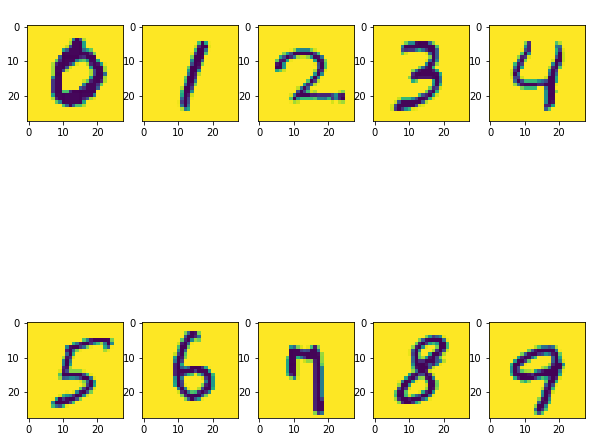

In [0]:
# 컨투어 내부 이미지 구현
fig = plt.figure(figsize = (10,10))

for num in range(1,11):
  ax = fig.add_subplot(2,5,num)
  ax.imshow(img_data[num-1])
  ax.set_title(str(num-1),fontsize = 15, color = 'w')

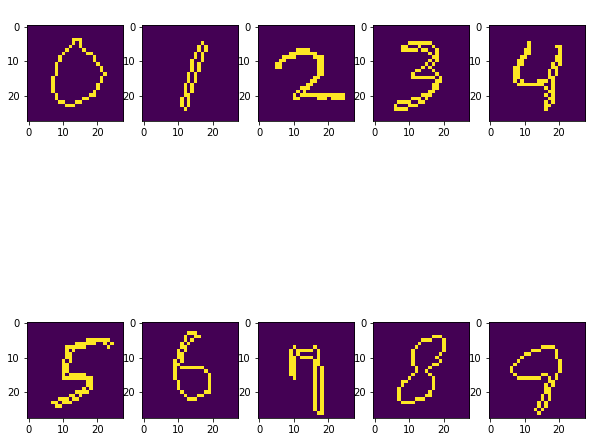

In [0]:
# 컨투어 이미지 확인
fig = plt.figure(figsize = (10,10))

for num in range(1,11):
  ax = fig.add_subplot(2,5,num)
  ax.imshow(img_data_countour[num-1])
  ax.set_title(str(num-1),fontsize = 15, color = 'w')

# 이미지 데이터 처리하기

## 무게중심 구하기

In [0]:
def calculateCenter(img_num):
  # 무게중심 구하기
  img_num = img_num

  height = img_data[img_num].shape[0]
  width = img_data[img_num].shape[1]

  R = list()
  for y in range(height):
    for x in range(width):
      if img_data[img_num][y,x]:            
        R.append([x, (height-y)*1j])

  # 질량의 합
  M = len(R)

  # 질량중심 벡터는 이미지를 기준으로 (x,y) => (height-y)
  R = np.array(R)
  R_x = R[:,0]
  R_y = R[:,1]

  R_x_sum = R_x.sum()
  R_y_sum = R_y.sum()

  center = np.round(R_x_sum/M).real , (np.round(R_y_sum/M)*-1j).real
 
  height_center = center[1]
  width_center = center[0]
  return width_center, height_center, M, R

In [0]:
for i in range(9):
  print(str(i), ':', 'width_center = ', calculateCenter(i)[0], '     ' , 'height_center = ', calculateCenter(i)[1], '     ' , 'M = ', calculateCenter(i)[2])

0 : width_center =  13.0       height_center =  15.0       M =  781
1 : width_center =  13.0       height_center =  14.0       M =  784
2 : width_center =  14.0       height_center =  14.0       M =  783
3 : width_center =  14.0       height_center =  14.0       M =  783
4 : width_center =  13.0       height_center =  14.0       M =  783
5 : width_center =  13.0       height_center =  14.0       M =  783
6 : width_center =  14.0       height_center =  15.0       M =  781
7 : width_center =  14.0       height_center =  14.0       M =  783
8 : width_center =  13.0       height_center =  15.0       M =  783


## 벡터그리기

In [0]:
# 벡터 그리기
def drawVector(img_num):
  height = img_data_countour[img_num].shape[0]
  width = img_data_countour[img_num].shape[1]

  fig = plt.figure(figsize = (10,10))
  ax = fig.gca()
  ax.set_xlim([-width, 2*width])
  ax.set_ylim([-height,2*height])
  all_vectors = list()
  for y in range(img_data_countour[img_num].shape[0]):
    for x in range(img_data_countour[img_num].shape[1]):
      if img_data_countour[img_num][y,x]:        
        # 이미지 상에서 (x,y)로 나타내자
        all_vectors.append(    [ x-calculateCenter(img_num)[0], (height - y) - calculateCenter(img_num)[1] ])
        ax.quiver(calculateCenter(img_num)[0],calculateCenter(img_num)[1],x-calculateCenter(img_num)[0], (height - y) - calculateCenter(img_num)[1] , angles='xy', scale_units='xy',scale=1, width = 0.001)
        
  sum_vector1 = np.array([np.array(all_vectors)[:,0].sum(), np.array(all_vectors)[:,1].sum()]) # (x,y)
  ax.quiver(calculateCenter(img_num)[0],calculateCenter(img_num)[1],sum_vector1[0], sum_vector1[1] , angles='xy', scale_units='xy',scale=1, color = 'r')

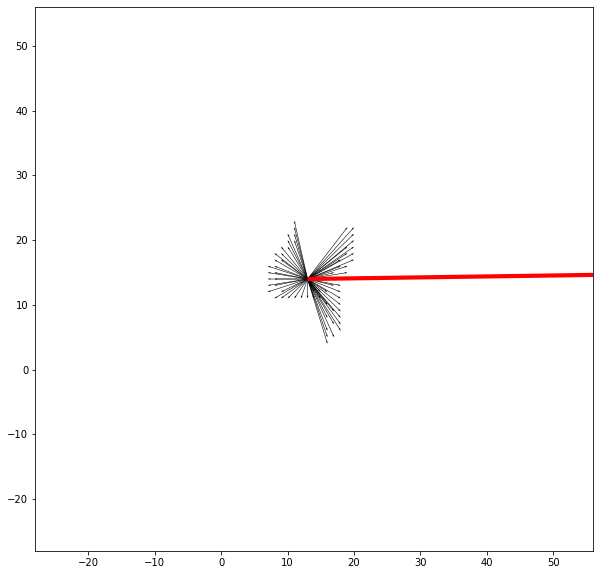

In [0]:
drawVector(4)

## 푸리에 시리즈 구현해보기

In [0]:
# 벡터 그리기
def dimensionExpansion(img_num):
  height = img_data_countour[img_num].shape[0]
  width = img_data_countour[img_num].shape[1]

  all_vectors = list()
  for y in range(img_data_countour[img_num].shape[0]):
    for x in range(img_data_countour[img_num].shape[1]):
      if img_data_countour[img_num][y,x]:        
        # 이미지 상에서 (x,y)로 나타내자
        all_vectors.append(    [ x-calculateCenter(img_num)[0], (height - y) - calculateCenter(img_num)[1] ])
  return np.array(all_vectors)

In [0]:
all_vectors = dimensionExpansion(6)
# all_vectors_size = np.sqrt(all_vectors[:,0]**2 + all_vectors[:,1]**2)
# all_vectors_angle = np.arcsin(all_vectors[:,1]/all_vectors_size) # 라디안 값으로 주어진다



In [0]:
# 1,2,3,4 사분면을 나눠보자
first   = list()
second  = list()
third   = list()
fourth  = list()
first_dict    = dict()
second_dict   = dict()
third_dict    = dict()
fourth_dict   = dict()
for i in all_vectors:
  x,y = i
  if x >= 0 and y >= 0:
    size1 = np.sqrt(x**2 + y**2)
    theta1 = np.arccos(x/size1)
    first.append([x,y,size1,theta1]) # [x,y,size1,theta1]
    # print('1사분면: ' , x,y)
  if x < 0 and y >= 0:
    size2 = np.sqrt(x**2 + y**2)
    theta2 = np.arccos(x/size2)
    second.append([x,y,size2, theta2])
    # print('2사분면: ', x,y)
  if x < 0 and y < 0:
    size3 = np.sqrt(x**2 + y**2)
    theta3 = np.arccos(x/size3) + PI
    third.append([x,y,size3, theta3])
    # print('3사분면: ', x,y)
  if x >= 0 and y < 0:
    size4 = np.sqrt(x**2 + y**2)
    theta4 = np.arccos(y/size4) + PI
    fourth.append([x,y,size4, theta4])
    # print('4사분면: ', x,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [0]:
third

[[-5.0, -1.0, 5.0990195135927845, 6.085789747329706],
 [-5.0, -2.0, 5.385164807134504, 5.902678930067221],
 [-5.0, -3.0, 5.830951894845301, 5.742765806909002],
 [-4.0, -4.0, 5.656854249492381, 5.497787143782138],
 [-4.0, -5.0, 6.4031242374328485, 5.387129922608242],
 [-4.0, -6.0, 7.211102550927978, 5.3003915839322575],
 [-3.0, -7.0, 7.615773105863909, 5.117280766669773],
 [-2.0, -8.0, 8.246211251235321, 4.957367643511554],
 [-1.0, -9.0, 9.055385138137417, 4.8230462015585855]]

<hr>

# 해봅시다

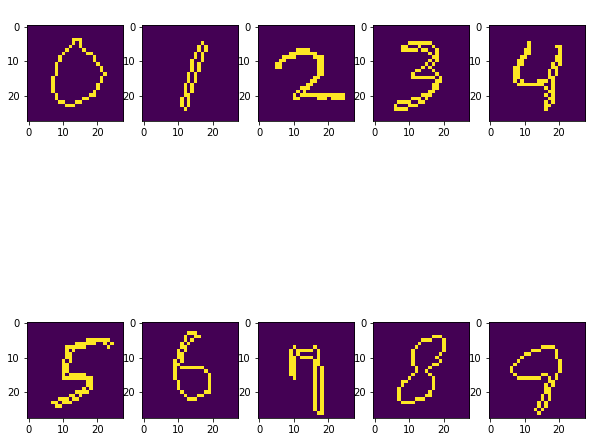

In [0]:
# 컨투어 이미지 확인
fig = plt.figure(figsize = (10,10))

for num in range(1,11):
  ax = fig.add_subplot(2,5,num)
  ax.imshow(img_data_countour[num-1])
  ax.set_title(str(num-1),fontsize = 15, color = 'w')

In [0]:
all_vectors = dimensionExpansion(0)

In [0]:
all_vectors.shape

(47, 2)

In [0]:
all_vectors[:,0]

In [0]:
all_vectors[:,0]

array([ 0.,  1.,  2.,  0.,  2., -1.,  2., -2.,  3., -3.,  4.,  5., -4.,
        6., -4.,  6., -5.,  7., -5.,  8., -5.,  8., -5.,  9., -6.,  8.,
       -6.,  8., -6.,  7., -6.,  7., -6.,  6., -5.,  5.,  6., -5.,  3.,
        4., -4., -3.,  1.,  2., -2., -1.,  0.])

In [0]:
all_vectors[:,1]

array([  9.,   9.,   9.,   8.,   8.,   7.,   7.,   6.,   6.,   5.,   5.,
         5.,   4.,   4.,   3.,   3.,   2.,   2.,   1.,   1.,   0.,   0.,
        -1.,  -1.,  -2.,  -2.,  -3.,  -3.,  -4.,  -4.,  -5.,  -5.,  -6.,
        -6.,  -7.,  -7.,  -7.,  -8.,  -8.,  -8.,  -9.,  -9.,  -9.,  -9.,
       -10., -10., -10.])

In [0]:
# 수치형으로 변환
ori_data = all_vectors
ori_data = ori_data.astype(int)

In [0]:
# 기준잡기, y=0, x=max
y_0 = ori_data[ori_data[:,1]==0]
# y_0_idx = y_0.argmax()
y_0_val = y_0.max(0)

# 정리
base = ori_data[ori_data[:,1]==0].max(0)
base

array([8, 0])

In [0]:
# 기준잡기 clean ver
def find_base(ori_data):
  ori_data = ori_data.astype(int)
  base = ori_data[ori_data[:,1]==0].max(0)
  return np.array([base[0]]), base[1]
find_base(ori_data)

(array([8]), 0)

In [0]:
# data 복사본
tmp = ori_data
tmp1 =np.array([6,0])
tmp2 =np.array([7,0])
tmp3 =np.array([8,0])
tmp4 =np.array([9,0])
tmp5 =np.array([10,0])
tmp6 =np.array([15,0])
tmp = np.array([tmp1, tmp2, tmp3, tmp4, tmp5, tmp6])

# 한 점에서 x축으로 이어진 점들을 본다
x_left = True
x_left_idx = base[0]-1
x_right = True
x_right_idx = base[0]

# x_list = list()
x_list = np.array( [base] )

while x_left:
  # print(x_left_idx)

  n = np.where( (tmp[:,1] == base[1]) & (tmp[:,0] == x_left_idx) )
  print(n[0])
  if len(n[0]) == 1:
    # print("in")
    x_left_idx -= 1
    x_list = np.append(x_list, tmp[n[0]], axis=0)
    tmp = np.delete(tmp, [n[0]], 0)
  else:
    x_left = False
while x_right:
  # print(x_right_idx)
  n = np.where( (tmp[:,1] == base[1]) & (tmp[:,0] == x_right_idx) )
  # print(n)
  if len(n[0]) == 1:
    x_right_idx += 1
    x_list = np.append(x_list, tmp[n[0]], axis=0)
    tmp = np.delete(tmp, [n[0]], 0)
  else:
    x_right = False

print(x_list)
print(tmp)

[1]
[0]
[]
[[ 8  0]
 [ 7  0]
 [ 6  0]
 [ 8  0]
 [ 9  0]
 [10  0]]
[[15  0]]


In [0]:
# clean ver
def find_close_x(ori_data, base_x_list, y):
  if len(base_x_list) > 1:
    for x in base_x_list:
      n = np.where( (ori_data[:,1] == y) & (ori_data[:,0] == x)  )
      if len(n[0]) == 1:
        base_x = ori_data[n[0]]
        break
    base = np.array([base_x[0][0], y])

  # OK, 위에거 해결하면 된다.
  
  else: # base_x_list => 1개
    base = np.array([base_x_list[0], y])
    # print("asd")

  print(base)
  x_left = True
  x_right = True
  x_left_idx = base[0]-1
  x_right_idx = base[0]+1
  # print(x_left_idx)
  # print(x_right_idx)

  result_list = np.array([base])
  n = np.where( (ori_data[:,1] == y) & (ori_data[:,0] == base[0]) )
  ori_data = np.delete(ori_data, n[0], 0)
  # print(result_list)

  while x_left:
    n = np.where( (ori_data[:,1] == y) & (ori_data[:,0] == x_left_idx) )
    if len(n[0]) == 1:
      x_left_idx -= 1
      result_list = np.append(result_list, tmp[n[0]], axis=0)
      ori_data = np.delete(ori_data, n[0], 0)
    else:
      x_left = False
    
  while x_right:
    n = np.where( (ori_data[:,1] == y) & (ori_data[:,0] == x_right_idx) )
    if len(n[0]) == 1:
      x_right_idx += 1
      result_list = np.append(result_list, tmp[n[0]], axis=0)
      ori_data = np.delete(ori_data, n[0], 0)
    else:
      x_right = False
  
  x_list = result_list[:,0]
  
  return result_list,x_list, ori_data
  # return result_list,x_list

find_close_x(ori_data, find_base(ori_data)[0], find_base(ori_data)[1])
# find_close_x(tmp, np.array([1,3,5,8]), find_base(ori_data)[1])
# find_close_x(tmp, np.array([8]), find_base(ori_data)[1])
# find_close_x(tmp, np.array([1,2,3,4,5,6,7,8,9]), find_base(ori_data)[1])
# find_close_x(ori_data, np.array([1,2,3,4,5,6,7,8,9]), find_base(ori_data)[1])

[8 0]


(array([[8, 0]]), array([8]), array([[  0,   9],
        [  1,   9],
        [  2,   9],
        [  0,   8],
        [  2,   8],
        [ -1,   7],
        [  2,   7],
        [ -2,   6],
        [  3,   6],
        [ -3,   5],
        [  4,   5],
        [  5,   5],
        [ -4,   4],
        [  6,   4],
        [ -4,   3],
        [  6,   3],
        [ -5,   2],
        [  7,   2],
        [ -5,   1],
        [  8,   1],
        [ -5,   0],
        [ -5,  -1],
        [  9,  -1],
        [ -6,  -2],
        [  8,  -2],
        [ -6,  -3],
        [  8,  -3],
        [ -6,  -4],
        [  7,  -4],
        [ -6,  -5],
        [  7,  -5],
        [ -6,  -6],
        [  6,  -6],
        [ -5,  -7],
        [  5,  -7],
        [  6,  -7],
        [ -5,  -8],
        [  3,  -8],
        [  4,  -8],
        [ -4,  -9],
        [ -3,  -9],
        [  1,  -9],
        [  2,  -9],
        [ -2, -10],
        [ -1, -10],
        [  0, -10]]))

In [0]:
a = np.array([1,2,3,4])
for i in a:
  print(i)

1
2
3
4


In [0]:
def change_y():
  

In [0]:
type(tmp)

numpy.ndarray

In [0]:
np.where( (tmp[:,1] == base[1]) & (tmp[:,0] == 8) )[0]

array([21])

In [0]:
tmp[21]

array([8, 0])

In [0]:
tmp[21]

array([8, 0])

In [0]:
n = np.where( (tmp[:,1] == base[1]) & (tmp[:,0] == 8) )
tmp[n[0]]

array([[8, 0]])

In [0]:
n = np.where( (tmp[:,1] == base[1]) & (tmp[:,0] == 9) )
# tmp[n]
if n[0]:
  print("asd")
else:
  print("qwe")

qwe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:

tmp1 =np.array([6,0])
tmp2 =np.array([7,0])
tmp3 =np.array([8,0])
tmp4 =np.array([9,0])
tmp5 =np.array([10,0])
tmp6 =np.array([15,0])
tmp = np.array([tmp1, tmp2, tmp3, tmp4, tmp5,tmp6])
tmp

n = np.where( (tmp[:,1] == base[1]) & (tmp[:,0] == 2) )
len(n[0])
# print(n)
# tmp[n[0]]


# tmp = np.delete(tmp, 3, 0)
# tmp

0

In [0]:


x_list = np.array( [base] )
x_list
x_list = np.append(x_list, [base], axis=0)
x_list.shape

x_list = np.append(x_list, [base], axis=0)
x_list.shape
x_list = np.append(x_list, [base], axis=0)
x_list.shape
x_list = np.append(x_list, [base], axis=0)
x_list.shape
len(x_list)

5

In [0]:
type(base)

numpy.ndarray